In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

from sklearn.metrics.cluster import rand_score
from sklearn.metrics import silhouette_score

from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn_som.som import SOM



# **ПЕРВЫЙ ДАТАСЕТ**

In [2]:
X_binary, y_binary = make_classification(n_samples=300, n_features=2, n_redundant=0, n_classes=2, random_state=999)  

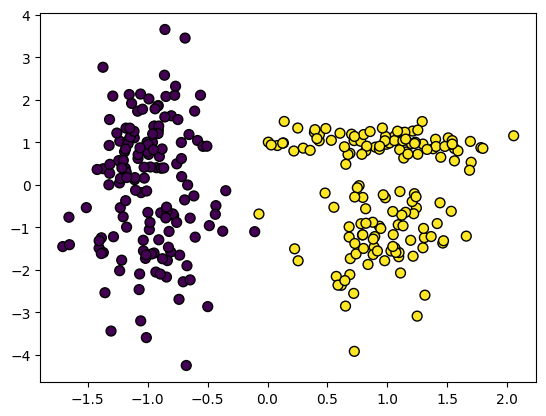

In [3]:
# как видит классификатор - с метками 
plt.scatter(X_binary[:, 0], X_binary[:, 1], marker="o", c=y_binary, s=50, edgecolor="k")
plt.show()

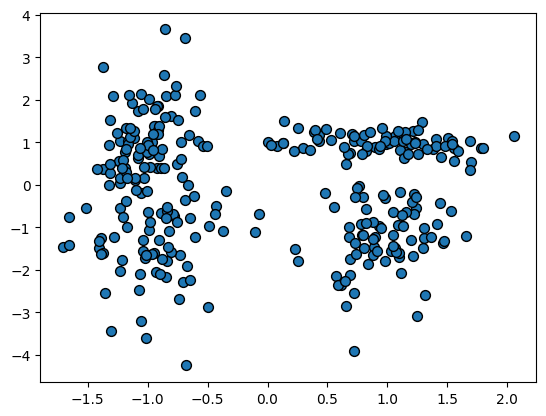

In [4]:
# как видит кластеризатор - без меток
plt.scatter(X_binary[:, 0], X_binary[:, 1], s=50, edgecolor="k")
plt.show()

# Кластеризация (всеми методами)

*K-means*

**без подбора**  гиперпараметров

In [5]:

simple_kmeans = KMeans(2, n_init='auto').fit(X_binary)

print('rand_score:', rand_score(simple_kmeans.labels_, y_binary)) # внешняя
print('silhouette_score:', silhouette_score(X_binary, simple_kmeans.labels_)) # внутренняя

rand_score: 0.4997547380156076
silhouette_score: 0.43312167331650897


**Подбор гиперпараметров**

*Метод локтя*

Inertia - within-cluster sum of squares criterion. The lower the better

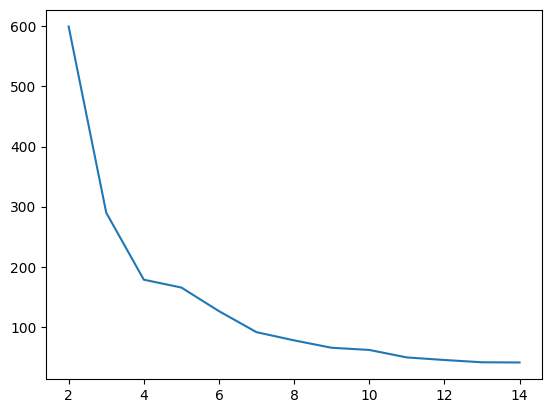

In [6]:
inertias = []

for i in range(2, 15):
  m = KMeans(i, n_init='auto').fit(X_binary)
  inertias.append(m.inertia_) # minimize it 

plt.plot(range(2,15), inertias)

*Метод силуэта*  - the greater the better

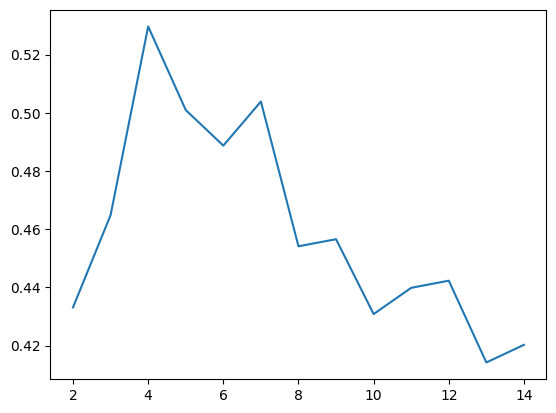

In [7]:
from sklearn.metrics import silhouette_score

ss = []

for i in range(2, 15):
  ss.append(silhouette_score(X_binary, KMeans(i, n_init='auto').fit(X_binary).labels_))

plt.plot(range(2,15), ss) 

**C подбором**  гиперпараметров

In [8]:
kmeans = KMeans(4, n_init='auto').fit(X_binary) # с гиперпараметром подобранный методом силуэта

print('rand_score:', rand_score(kmeans.labels_, y_binary))
print('silhouette_score:', silhouette_score(X_binary, kmeans.labels_))

rand_score: 0.7499888517279821
silhouette_score: 0.5296408470206615


### *Визуализация до/после включения гиперпараметров* 

**ДО**

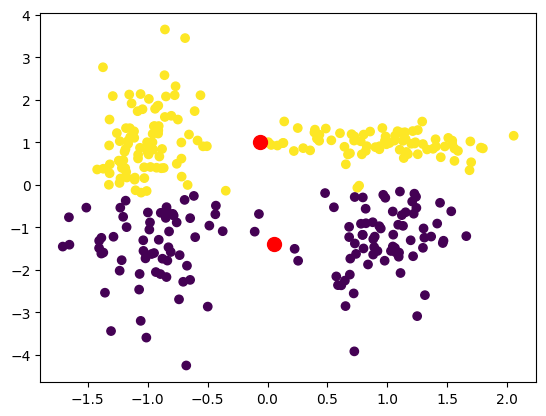

In [9]:
plt.scatter(X_binary[:,0], X_binary[:,1], c=simple_kmeans.labels_)
plt.scatter(simple_kmeans.cluster_centers_[:,0], simple_kmeans.cluster_centers_[:,1], s=100, c='red')

**ПОСЛЕ**

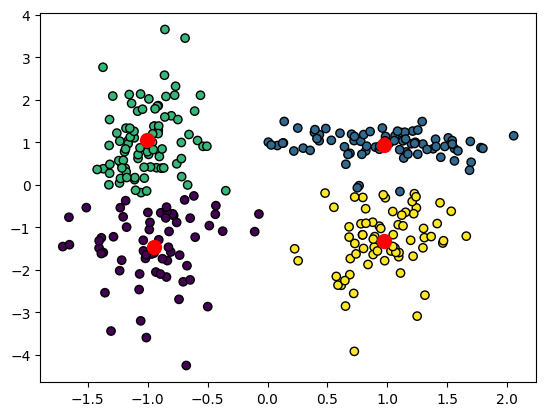

In [10]:
plt.scatter(X_binary[:,0], X_binary[:,1], c=kmeans.labels_, edgecolor="k")
plt.scatter([kmeans.cluster_centers_[:,0]], kmeans.cluster_centers_[:,1],  s=100, c='red')

В самом деле видно, что разделилось в разу лучше, чем без гиперпараметров

*Affinity Propagation*

In [11]:
simple_affinity = AffinityPropagation().fit(X_binary)


print('rand_score:', rand_score(simple_affinity.labels_, y_binary))
print('silhouette_score:', silhouette_score(X_binary, simple_affinity.labels_))

rand_score: 0.6087179487179487
silhouette_score: 0.42789224250500213


***Вспомогательная функция поиска гиперпараметров:***

In [12]:
def hyperparam_search(params: [], X, y, method_name: str):
    # methods_names = {'SOM', 'DB-SCAN', 'GaussianMixture', 'AffinityPropagation', 'AgglomerativeClustering'}
    pare = ()
    max = 0
    # if method_name not in methods_names: 
    for p0 in params[0]:  # params - array with length 2
            for p1 in params[1]:
                if method_name == 'SOM':
                    som = SOM(m=p0, n=p1,dim= X.shape[1])  
                    som.fit(X)
                    labels = som.predict(X)

                elif method_name == 'DB-SCAN':
                    dbscan = DBSCAN(eps=p0, min_samples=p1).fit(X)
                    labels = dbscan.labels_
                    # print(labels.shape)
                    if np.unique(labels).shape[0] == 1:
                        dbscan = DBSCAN(eps=p0).fit(X)
                        labels = dbscan.labels_
                    
                elif method_name == 'GaussianMixture':
                    gm = GaussianMixture(n_components=p0, covariance_type=p1).fit(X)
                    labels = gm.predict(X)

                elif method_name == 'AffinityPropagation':
                    ap = AffinityPropagation(damping=p0, max_iter=p1).fit(X)
                    labels = ap.labels_

                elif method_name == 'AgglomerativeClustering':
                    clustering = AgglomerativeClustering(n_clusters=p0, linkage=p1).fit(X)
                    labels = clustering.labels_

                else: print("Нет такого метода!")
                if rand_score(labels, y) + silhouette_score(X, labels) > max:
                    max = rand_score(labels, y) + silhouette_score(X, labels)
                    pare = (p0,p1)
    return pare


In [13]:
damping=  [0.5, 0.7, 0.9]
max_iter= [100,200, 300]

p0, p1 = hyperparam_search([damping, max_iter], X_binary, y_binary, 'AffinityPropagation')

hyperparam_ap = AffinityPropagation(damping = p0, max_iter=p1).fit(X_binary)
labels = hyperparam_ap.labels_
print('rand_score:', rand_score(labels, y_binary))
print('silhouette_score:', silhouette_score(X_binary, labels))

rand_score: 0.6029208472686733
silhouette_score: 0.4395071661288883


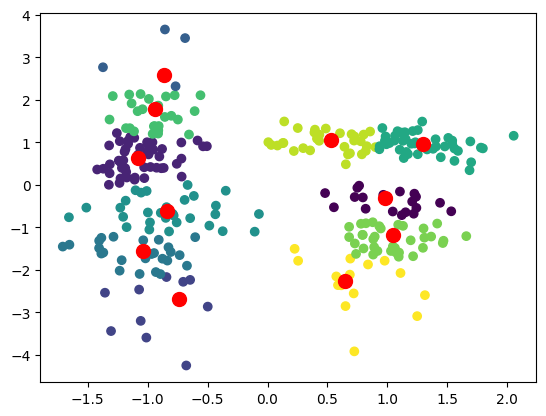

In [14]:
plt.scatter(X_binary[:,0], X_binary[:,1], c= simple_affinity.labels_)
plt.scatter(simple_affinity.cluster_centers_[:,0], simple_affinity.cluster_centers_[:,1], s=100, c='red')

*DB-SCAN*

In [15]:
simple_dbscan = DBSCAN().fit(X_binary)
print('rand_score:', rand_score(simple_dbscan.labels_, y_binary))
print('silhouette_score:', silhouette_score(X_binary, simple_dbscan.labels_))

rand_score: 0.8408695652173913
silhouette_score: 0.40760771900820525


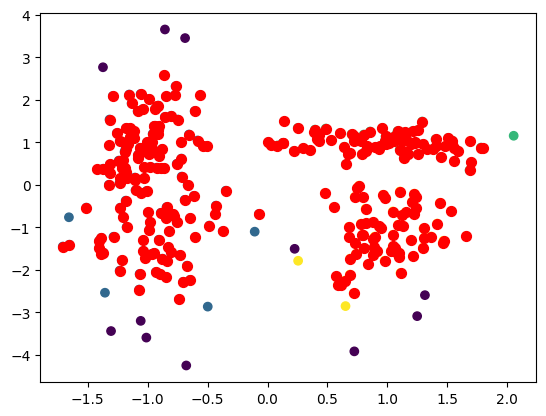

In [16]:
plt.scatter(X_binary[:,0], X_binary[:,1], c=simple_dbscan.labels_)
plt.scatter(simple_dbscan.components_[:,0], simple_dbscan.components_[:,1], s=50, c='red')

In [17]:
eps = [0.5, 0.9, 0.1]
min_samples =[4, 5, 6, 7, 8, 9, 10]

p0, p1 = hyperparam_search([eps, min_samples], X_binary, y_binary, 'DB-SCAN')

hyperparam_model = DBSCAN(eps = p0, min_samples=p1).fit(X_binary)

print(f'rand_score: {rand_score(hyperparam_model.labels_, y_binary)}\n\
silhouette_score: {silhouette_score(X_binary, hyperparam_model.labels_)}')

rand_score: 0.8424749163879599
silhouette_score: 0.4104456851638232


## Gaussian Mixtures

In [55]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(X_binary)

labels = gm.predict(X_binary)
print('rand_score:', rand_score(labels, y_binary))
print('silhouette_score:', silhouette_score(X_binary, labels))

rand_score: 0.9933333333333333
silhouette_score: 0.37402059872131127


saving and loading model for RGR

In [59]:
import joblib

joblib.dump(gm, "../models/MODEL_TWO_binary_classification")

['../models/MODEL_TWO_binary_classification']

In [60]:
test = joblib.load("../models/MODEL_TWO_binary_classification")

In [65]:
labels = test.predict(X_binary)

print('rand_score:', rand_score(labels, y_binary))
print('silhouette_score:', silhouette_score(X_binary, labels))

rand_score: 0.9933333333333333
silhouette_score: 0.37402059872131127


In [ ]:
n_components = [2, 3, 4, 5, 6, 8, 9]
cov_type = ['full', 'tied', 'diag']

p0, p1 = hyperparam_search([n_components, cov_type], X_binary, y_binary, 'GaussianMixture')

hyperparam_model = GaussianMixture(n_components= p0, covariance_type= p1).fit(X_binary)
labels = hyperparam_model.predict(X_binary)

print('rand_score:', rand_score(labels, y_binary))
print('silhouette_score:', silhouette_score(X_binary, labels))

rand_score: 0.7493645484949832
silhouette_score: 0.5246984639450907


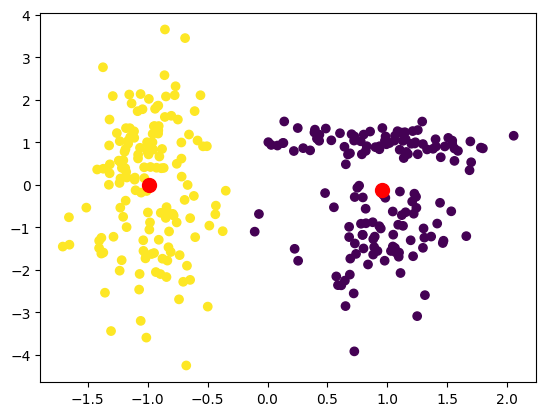

In [56]:
plt.scatter(X_binary[:,0], X_binary[:,1], c=gm.predict(X_binary))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=100, c='red')

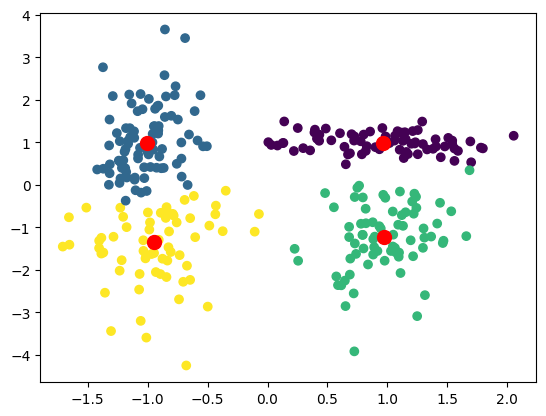

In [33]:
plt.scatter(X_binary[:,0], X_binary[:,1], c= labels)
plt.scatter(hyperparam_model.means_[:,0], hyperparam_model.means_[:,1], s=100, c='red')

*Self-Organizing Maps*

In [22]:
# %pip install sklearn_som

In [23]:
som = SOM(dim= X_binary.shape[1])  
som.fit(X_binary)
labels = som.predict(X_binary)

In [24]:
print(f'rand_score: {rand_score(labels, y_binary)}\nsilhouette_score: {silhouette_score(X_binary, labels)}')

rand_score: 0.6214715719063545
silhouette_score: 0.35447747966512827


In [25]:
ms = [2,3,4,5]
ns = [1,2,3,4,5]
params = [ms, ns]

pare = hyperparam_search(params=params, X=X_binary, y=y_binary, method_name= 'SOM')
optimal_m = pare[0]
optimal_n = pare[1]

som = SOM(dim= X_binary.shape[1], m=optimal_m, n=optimal_n, lr=0.5, sigma=0.1)  
som.fit(X_binary)
labels = som.predict(X_binary)
print(f'rand_score: {rand_score(labels, y_binary)}\nsilhouette_score: {silhouette_score(X_binary, labels)}')

rand_score: 0.6777257525083612
silhouette_score: 0.4702886360589064


*AgglomerativeClustering*

In [26]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X_binary)
print(f'rand_score: {rand_score(clustering.labels_, y_binary)}\nsilhouette_score: {silhouette_score(X_binary, clustering.labels_)}')

rand_score: 0.6549386845039019
silhouette_score: 0.4201880232944194


In [27]:
n_clusters= [2,3,4,5,6] 
linkage= ["ward", "complete", "average", "single"]

p0, p1 = hyperparam_search([n_clusters, linkage], X_binary, y_binary, 'AgglomerativeClustering')

hyperparam_model = AgglomerativeClustering(n_clusters= p0, linkage= p1).fit(X_binary)

print(f'rand_score: {rand_score(hyperparam_model.labels_, y_binary)}\n\
silhouette_score: {silhouette_score(X_binary, hyperparam_model.labels_)}')

rand_score: 0.7401114827201783
silhouette_score: 0.5192923400473408


# **ВТОРОЙ ДАТАСЕТ**

In [28]:
X_with_reduntant, y_with_reduntant = make_classification(n_samples=300, n_features=4, n_redundant=2, n_classes=2, random_state=43)  

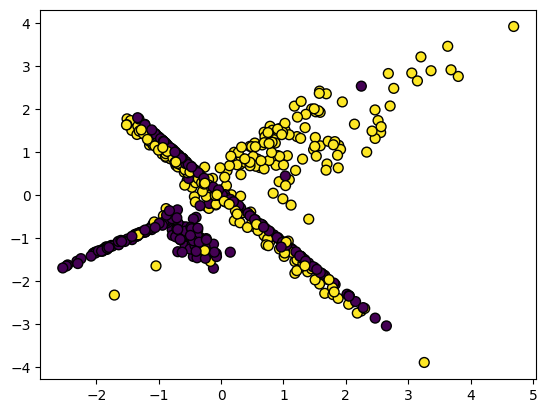

In [29]:
plt.scatter(X_with_reduntant[:, 0], X_with_reduntant[:, 1], marker="o", c=y_with_reduntant, s=50, edgecolor="k")
plt.scatter(X_with_reduntant[:, 2], X_with_reduntant[:, 3], marker="o", c=y_with_reduntant, s=50, edgecolor="k")

plt.show()


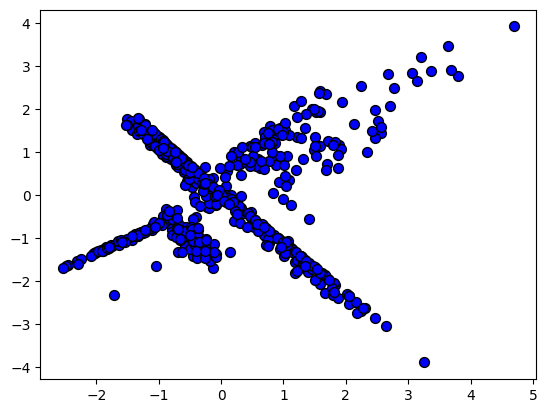

In [30]:
plt.scatter(X_with_reduntant[:, 0], X_with_reduntant[:, 1], marker="o", c='b',s=50, edgecolor="k")
plt.scatter(X_with_reduntant[:, 2], X_with_reduntant[:, 3], marker="o", c='b',s=50, edgecolor="k")

plt.show()

 K-MEANS

In [31]:
simple_kmeans = KMeans(n_init='auto').fit(X_with_reduntant)

print('rand_score:', rand_score(simple_kmeans.labels_, y_with_reduntant)) # внешняя
print('silhouette_score:', silhouette_score(X_with_reduntant, simple_kmeans.labels_)) # внутренняя

rand_score: 0.602742474916388
silhouette_score: 0.42991360186724764


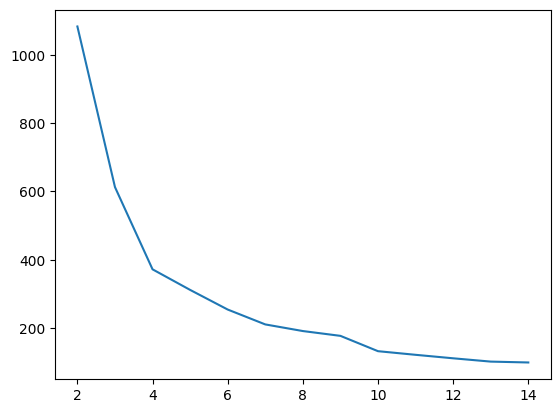

In [32]:
inertias = []

for i in range(2, 15):
  m = KMeans(i, n_init='auto').fit(X_with_reduntant)
  inertias.append(m.inertia_) # minimize it 

plt.plot(range(2,15), inertias)

Очевидно, лучший параметр - 4 - место локтевого сгиба, а дальше всё более-менее плавно

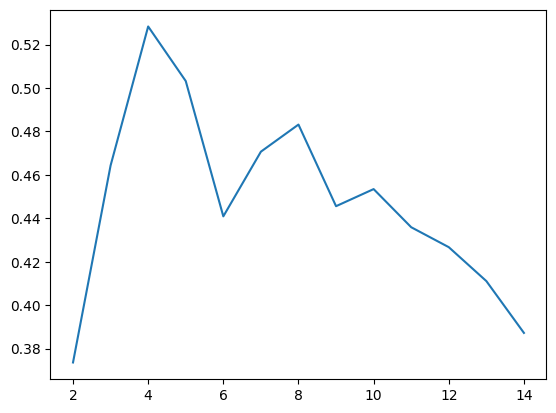

In [33]:
ss = []
for i in range(2, 15):
  ss.append(silhouette_score(X_binary, KMeans(i, n_init='auto').fit(X_binary).labels_))

plt.plot(range(2,15), ss) 

In [34]:
kmeans_with_hypers = KMeans(4, n_init='auto').fit(X_with_reduntant) 

print('rand_score:', rand_score(kmeans_with_hypers.labels_, y_with_reduntant))
print('silhouette_score:', silhouette_score(X_with_reduntant, kmeans_with_hypers.labels_))

rand_score: 0.6667335562987737
silhouette_score: 0.5256368589291893


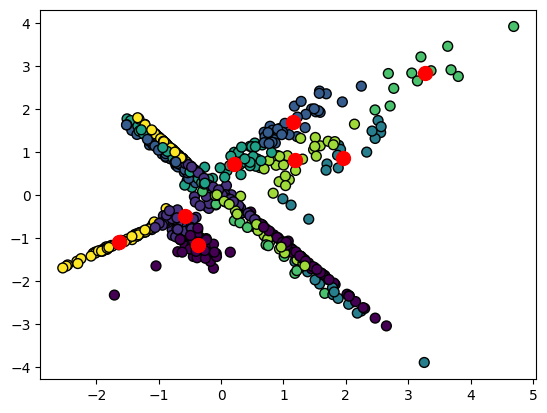

In [35]:
plt.scatter(X_with_reduntant[:, 0], X_with_reduntant[:, 1], marker="o", c=simple_kmeans.labels_, s=50, edgecolor="k")
plt.scatter(X_with_reduntant[:, 2], X_with_reduntant[:, 3], marker="o", c=simple_kmeans.labels_, s=50, edgecolor="k")

plt.scatter([simple_kmeans.cluster_centers_[:,0]], simple_kmeans.cluster_centers_[:,1],  s=100, c='red')

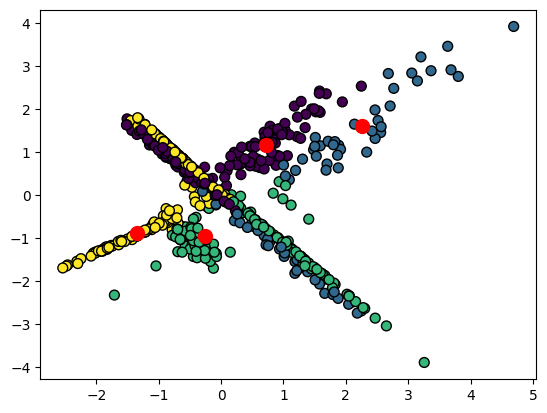

In [36]:
plt.scatter(X_with_reduntant[:, 0], X_with_reduntant[:, 1], marker="o", c=kmeans_with_hypers.labels_, s=50, edgecolor="k")
plt.scatter(X_with_reduntant[:, 2], X_with_reduntant[:, 3], marker="o", c=kmeans_with_hypers.labels_,s=50, edgecolor="k")

plt.scatter([kmeans_with_hypers.cluster_centers_[:,0]], kmeans_with_hypers.cluster_centers_[:,1],  s=100, c='red')

AffinityPropagation

In [37]:
simple_affinity = AffinityPropagation().fit(X_with_reduntant)


print('rand_score:', rand_score(simple_affinity.labels_, y_with_reduntant))
print('silhouette_score:', silhouette_score(X_with_reduntant, simple_affinity.labels_))

rand_score: 0.5565217391304348
silhouette_score: 0.388370305096175


In [38]:
damping=  [0.5, 0.7, 0.9]
max_iter= [100,200, 300]

p0, p1 = hyperparam_search([damping, max_iter], X_with_reduntant, y_with_reduntant, 'AffinityPropagation')

hyperparam_ap = AffinityPropagation(damping = p0, max_iter=p1).fit(X_with_reduntant)

/home/timofey/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [39]:
labels = hyperparam_ap.labels_
print('rand_score:', rand_score(labels, y_with_reduntant))
print('silhouette_score:', silhouette_score(X_with_reduntant, labels))

rand_score: 0.5671348940914158
silhouette_score: 0.42869967009665827


DB-SCAN

In [40]:
simple_dbscan = DBSCAN(eps=0.05, min_samples=5).fit(X_with_reduntant)  # eps по локтю


print('rand_score:', rand_score(simple_dbscan.labels_, y_with_reduntant))
print('silhouette_score:', silhouette_score(X_with_reduntant, simple_dbscan.labels_))

rand_score: 0.49988851727982164
silhouette_score: -0.14696465753508417


In [41]:
eps = [0.5, 0.05, 0.1]
min_samples =[4, 5, 6, 7, 8, 9, 10]

p0, p1 = hyperparam_search([eps, min_samples], X_with_reduntant, y_with_reduntant, 'DB-SCAN')

hyperparam_model = DBSCAN(eps = p0, min_samples=p1).fit(X_with_reduntant)

In [42]:
print('rand_score:', rand_score(hyperparam_model.labels_, y_with_reduntant))
print('silhouette_score:', silhouette_score(X_with_reduntant, hyperparam_model.labels_))


rand_score: 0.6827201783723523
silhouette_score: 0.4427375698055476


GaussianMixture

In [43]:
gm = GaussianMixture(n_components=2).fit(X_with_reduntant)

labels = gm.predict(X_with_reduntant)
print('rand_score:', rand_score(labels, y_with_reduntant))
print('silhouette_score:', silhouette_score(X_with_reduntant, labels))

rand_score: 0.9046822742474916
silhouette_score: 0.35276085684830333


In [44]:
n_components = [2, 3, 4, 5, 6, 8, 9]
cov_type = ['full', 'tied', 'diag']

p0, p1 = hyperparam_search([n_components, cov_type], X_with_reduntant, y_with_reduntant, 'GaussianMixture')

hyperparam_model = GaussianMixture(n_components= p0, covariance_type= p1).fit(X_with_reduntant)
labels = hyperparam_model.predict(X_with_reduntant)

print('rand_score:', rand_score(labels, y_with_reduntant))
print('silhouette_score:', silhouette_score(X_with_reduntant, labels))

rand_score: 0.9046822742474916
silhouette_score: 0.35276085684830333


SOM

In [45]:
som = SOM(dim= X_with_reduntant.shape[1])  
som.fit(X_with_reduntant)
labels = som.predict(X_with_reduntant)
print(f'rand_score: {rand_score(labels, y_with_reduntant)}\nsilhouette_score: {silhouette_score(X_with_reduntant, labels)}')

rand_score: 0.626577480490524
silhouette_score: 0.35203576325282243


In [46]:
ms = [2,3,4,5]
ns = [1,2,3,4,5]
params = [ms, ns]

pare = hyperparam_search(params=params, X=X_with_reduntant, y=y_with_reduntant, method_name= 'SOM')
optimal_m = pare[0]
optimal_n = pare[1]

som = SOM(dim= X_with_reduntant.shape[1], m=optimal_m, n=optimal_n, lr=0.5, sigma=0.1)  
som.fit(X_with_reduntant)
labels = som.predict(X_with_reduntant)
print(f'rand_score: {rand_score(labels, y_with_reduntant)}\nsilhouette_score: {silhouette_score(X_with_reduntant, labels)}')

rand_score: 0.6626978818283166
silhouette_score: 0.5268647438240637


Значительное улучшение результата!

AgglomerativeClustering

In [47]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering().fit(X_with_reduntant)
print(f'rand_score: {rand_score(clustering.labels_, y_with_reduntant)}\nsilhouette_score: {silhouette_score(X_with_reduntant, clustering.labels_)}')

rand_score: 0.5001337792642141
silhouette_score: 0.36227634670362124


In [48]:
n_clusters= [2,3,4,5,6] 
linkage= ["ward", "complete", "average", "single"]

p0, p1 = hyperparam_search([n_clusters, linkage], X_with_reduntant, y_with_reduntant, 'AgglomerativeClustering')

hyperparam_model = AgglomerativeClustering(n_clusters= p0, linkage= p1).fit(X_with_reduntant)

print(f'rand_score: {rand_score(hyperparam_model.labels_, y_with_reduntant)}\n\
silhouette_score: {silhouette_score(X_with_reduntant, hyperparam_model.labels_)}')

rand_score: 0.6876254180602007
silhouette_score: 0.5082321443305947


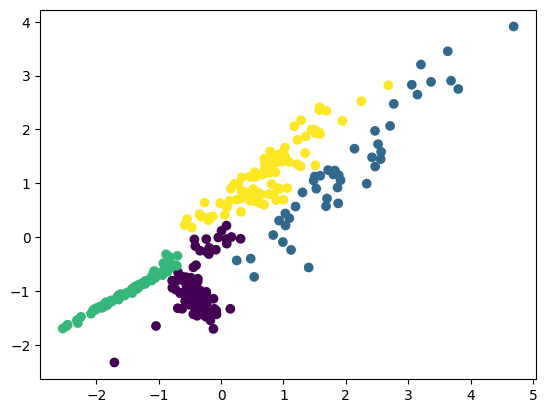

In [49]:
plt.scatter(X_with_reduntant[:,0], X_with_reduntant[:,1], c=hyperparam_model.labels_)

# **ТРЕТИЙ ДАТАСЕТ**

In [50]:
X_informative_only, y_informative_only = make_classification(n_samples=400, n_features=3, n_informative=3, n_redundant=0, n_classes=3, random_state=999)  

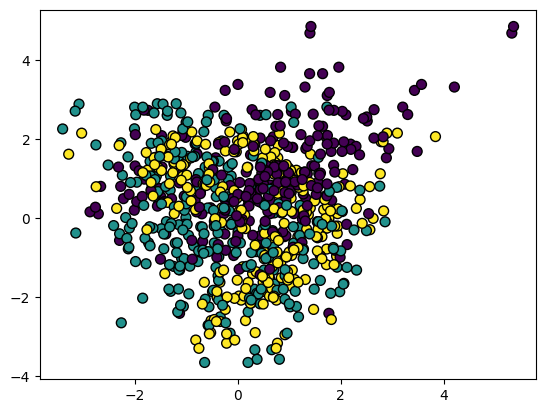

In [51]:
plt.scatter(X_informative_only[:, 0], X_informative_only[:, 1], marker="o", c=y_informative_only, s=50, edgecolor="k")
plt.scatter(X_informative_only[:, 2], X_informative_only[:, 1], marker="o", c=y_informative_only, s=50, edgecolor="k")

plt.show()  # 3d 

K-means

In [52]:
simple_kmeans = KMeans(n_init='auto').fit(X_informative_only)

print('rand_score:', rand_score(simple_kmeans.labels_, y_informative_only)) # внешняя
print('silhouette_score:', silhouette_score(X_informative_only, simple_kmeans.labels_)) # внутренняя

rand_score: 0.676015037593985
silhouette_score: 0.29352802090027014


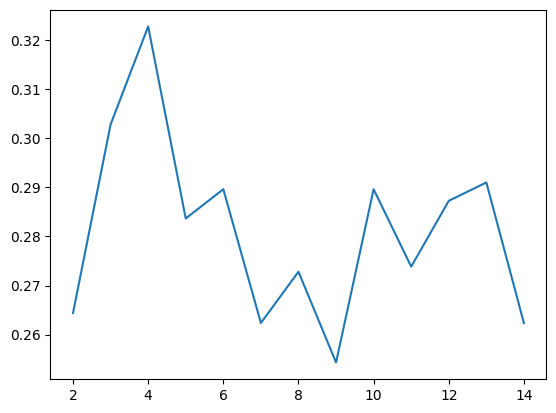

In [53]:
ss = []

for i in range(2, 15):
  ss.append(silhouette_score(X_informative_only, KMeans(i, n_init='auto').fit(X_informative_only).labels_))

plt.plot(range(2,15), ss) 

In [54]:
kmeans_with_hypers = KMeans(4, n_init='auto').fit(X_informative_only)

print('rand_score:', rand_score(kmeans_with_hypers.labels_, y_informative_only))
print('silhouette_score:', silhouette_score(X_informative_only, kmeans_with_hypers.labels_))

rand_score: 0.6507393483709273
silhouette_score: 0.32079988474369064


AffinityPropagation

In [55]:
simple_affinity = AffinityPropagation().fit(X_informative_only)


print('rand_score:', rand_score(simple_affinity.labels_, y_informative_only))
print('silhouette_score:', silhouette_score(X_informative_only, simple_affinity.labels_))

rand_score: 0.6829197994987468
silhouette_score: 0.27583513073615346


SOM

In [56]:
som = SOM(dim= X_informative_only.shape[1])  
som.fit(X_informative_only)
labels = som.predict(X_informative_only)
print(f'rand_score: {rand_score(labels, y_informative_only)}\nsilhouette_score: {silhouette_score(X_informative_only, labels)}')



rand_score: 0.6710526315789473
silhouette_score: 0.11215019657199321


In [57]:
ms = [1,2,3,4,5]
ns = [1,2,3,4,5]

pare = hyperparam_search(ms=ms, ns=ns, X=X_informative_only, y=y_informative_only)
optimal_m = pare[0]
optimal_n = pare[1]

TypeError: hyperparam_search() got an unexpected keyword argument 'ms'

In [ ]:
som = SOM(dim= X_informative_only.shape[1], m=optimal_m, n=optimal_n, lr=0.5, sigma=0.1)  
som.fit(X_informative_only)
labels = som.predict(X_informative_only)
print(f'rand_score: {rand_score(labels, y_informative_only)}\nsilhouette_score: {silhouette_score(X_informative_only, labels)}')

rand_score: 0.6819047619047619
silhouette_score: 0.24286063703768895


**Реализация K-Means**

In [ ]:
def kmeans(dataset, k, max_iterations=100):
    centroids = initialize_centroids(dataset, k)
    for _ in range(max_iterations):
        # Assign data points to the nearest centroid
        labels = assign_points(dataset, centroids)
        # print(labels)
        # Update centroids based on the assigned points
        new_centroids = update_centroids(dataset, labels, k)
        
        # Check for convergence (слияние)
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return labels, centroids

def initialize_centroids(dataset, k):
    indices = np.random.choice(len(dataset), k, replace=False)
    centroids = dataset[indices]
    return centroids

def assign_points(dataset, centroids):
    labels = np.zeros(len(dataset))
    for i, point in enumerate(dataset):
        # Calculate the Euclidean distance between each point and centroids
        distances = np.linalg.norm(centroids - point, axis=1) # норма разности
        # Assign the point to the nearest centroid
        labels[i] = np.argmin(distances)
    return labels

def update_centroids(dataset, labels, k):
    new_centroids = np.zeros((k, dataset.shape[1]))
    for i in range(k):
        # Find all points assigned to the current centroid
        points = dataset[labels == i]
        if len(points) > 0:
            # Calculate the mean of the assigned points to update the centroid
            new_centroids[i] = np.mean(points, axis=0)
    return new_centroids

dataset = np.array([[1, 2], [2, 3], [8, 7], [9, 8], [12, 10], [10, 9]])
k = 2

labels, centroids = kmeans(dataset, k)
print("Cluster labels:", labels)
print("Final centroids:", centroids)

Cluster labels: [1. 1. 0. 0. 0. 0.]
Final centroids: [[9.75 8.5 ]
 [1.5  2.5 ]]


In [ ]:
labels, centroids = kmeans(X_binary, 3)
print(f'rand_score: {rand_score(labels, y_binary)}\nsilhouette_score: {silhouette_score(X_binary, labels)}')

rand_score: 0.6876477146042363
silhouette_score: 0.4643280221363789


In [ ]:
labels, centroids = kmeans(X_with_reduntant, 3)
print(f'rand_score: {rand_score(labels, y_with_reduntant)}\nsilhouette_score: {silhouette_score(X_with_reduntant, labels)}')

rand_score: 0.6691638795986622
silhouette_score: 0.4634644767622422


In [ ]:
labels, centroids = kmeans(X_informative_only, 3)
print(f'rand_score: {rand_score(labels, y_informative_only)}\nsilhouette_score: {silhouette_score(X_informative_only, labels)}')

rand_score: 0.5953884711779449
silhouette_score: 0.2882441113370093


**Реализация DB-SCAN**

In [ ]:
from scipy.spatial import distance

def dbscan(dataset, eps, min_samples):
    labels = [0] * len(dataset)  # Initialize all data points as unvisited (label 0)
    cluster_id = 0  # Cluster ID counter

    for i in range(len(dataset)):
        if labels[i] != 0:  # Skip already visited data points
            continue

        neighbors = get_neighbors(dataset, i, eps)
        if len(neighbors) < min_samples:
            labels[i] = -1  # Mark as noise/outlier
        else:
            cluster_id += 1
            expand_cluster(dataset, labels, i, neighbors, cluster_id, eps, min_samples)

    return labels

def expand_cluster(dataset, labels, data_point_index, neighbors, cluster_id, eps, min_samples):
    labels[data_point_index] = cluster_id

    i = 0
    while i < len(neighbors):
        neighbor_index = neighbors[i]
        if labels[neighbor_index] == -1 or labels[neighbor_index] == 0:  # Change noise to border point/Unvisited point to visited
            labels[neighbor_index] = cluster_id
        # elif labels[neighbor_index] == 0:  # Unvisited point
            # labels[neighbor_index] = cluster_id
            new_neighbors = get_neighbors(dataset, neighbor_index, eps)
            if len(new_neighbors) >= min_samples:
                neighbors += new_neighbors
        i += 1

def get_neighbors(dataset, data_point_index, eps):
    return [i for i in range(len(dataset)) if distance.euclidean(dataset[data_point_index], dataset[i]) <= eps]

In [ ]:
res = dbscan(X_binary, eps=0.5, min_samples=5)
print('rand_score:', rand_score(res, y_binary))
print('silhouette_score:', silhouette_score(X_binary, res))

rand_score: 0.8408695652173913
silhouette_score: 0.40760771900820525


In [ ]:
res = dbscan(X_with_reduntant, eps=0.5, min_samples=5)
print('rand_score:', rand_score(res, y_with_reduntant))
print('silhouette_score:', silhouette_score(X_with_reduntant, res))

rand_score: 0.5455964325529543
silhouette_score: 0.17513664863178022


In [ ]:
res = dbscan(X_informative_only, eps=0.5, min_samples=5)
print('rand_score:', rand_score(res, y_informative_only))
print('silhouette_score:', silhouette_score(X_informative_only, res))

rand_score: 0.6186967418546366
silhouette_score: -0.13589863722624604


In [ ]:
X_informative_only.shape

(400, 3)

In [ ]:
np.array(res).shape

(300,)

# Задание 2 (кластеризация на датасете классификации)

In [ ]:
from imblearn.over_sampling import RandomOverSampler 

data = pd.read_csv('../data/smoke_detector_task.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data = data.drop('UTC', axis=1)

mean_group = ["TVOC[ppb]", "eCO2[ppm]", "PM2.5", 
              "NC1.0", "Humidity[%]", "Temperature[C]",
                "Raw H2", "Pressure[hPa]"]

for field in mean_group:
    data[field] = data[field].fillna(data[field].mean())

dict_firealarm = {"Yes": 1, "No": 0}
data["Fire Alarm"] = data["Fire Alarm"].map(dict_firealarm)

y = data['Fire Alarm'] # filtered_
X = data.drop(['Fire Alarm'], axis=1) #filtered_

X, y = RandomOverSampler(random_state=42).fit_resample(X, y)

X_clustering = X[:300]
y_clustering = y[:300]

In [ ]:
X_clustering = X_clustering.drop('CNT', axis=1)
 

In [ ]:
X_clustering

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
0,20.000,57.36,0.0,400.0,12306.0,18520,939.735,0.00,0.00,0.00,0.000,0.000
1,20.015,56.67,0.0,400.0,12345.0,18651,939.744,0.00,0.00,0.00,0.000,0.000
2,20.029,55.96,0.0,400.0,12374.0,18764,939.738,0.00,0.00,0.00,0.000,0.000
3,20.044,55.28,0.0,400.0,12390.0,18849,939.736,0.00,0.00,0.00,0.000,0.000
4,20.059,54.69,0.0,400.0,12403.0,18921,939.744,0.00,0.00,0.00,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
295,23.627,51.38,6.0,400.0,12666.0,19729,939.799,0.12,0.18,0.66,0.192,0.057
296,23.637,51.16,13.0,400.0,12662.0,19718,939.785,0.11,0.17,0.62,0.180,0.054
297,23.646,50.96,11.0,400.0,12669.0,19713,939.790,0.10,0.15,0.54,0.158,0.047
298,23.656,50.80,13.0,400.0,12661.0,19714,939.784,0.09,0.14,0.51,0.147,0.044


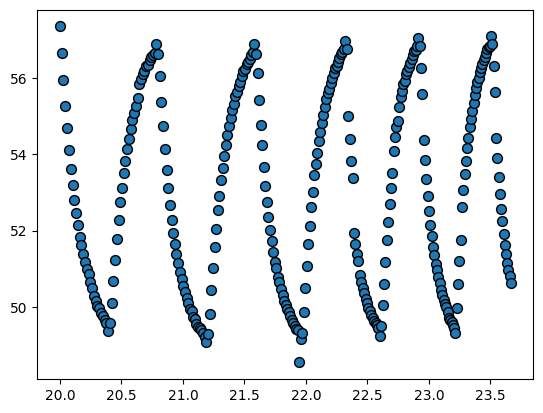

In [ ]:
plt.scatter(np.array(X_clustering)[:, 0], np.array(X_clustering)[:, 1], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 2], np.array(X_clustering)[:, 3], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 4], np.array(X_clustering)[:, 5], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 6], np.array(X_clustering)[:, 7], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 8], np.array(X_clustering)[:, 9], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 10], np.array(X_clustering)[:, 11], s=50, edgecolor="k")

plt.show()

In [ ]:
kmeans = KMeans(n_init='auto').fit(X_clustering)

labels = kmeans.labels_
print('rand_score:', rand_score(labels, np.array(y_clustering)))
print('silhouette_score:', silhouette_score(np.array(X_clustering), labels))

rand_score: 0.25137123745819395
silhouette_score: 0.4505478446142327


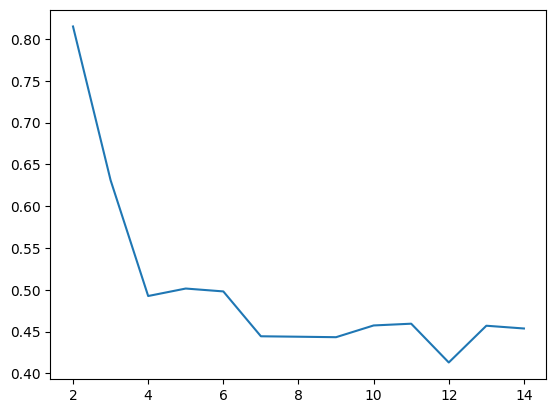

In [ ]:
ss = []

for i in range(2, 15):
  ss.append(silhouette_score(X_clustering, KMeans(i, n_init='auto').fit(X_clustering).labels_))

plt.plot(range(2,15), ss) 

In [ ]:
kmeans = KMeans(n_clusters=2,n_init='auto').fit(X_clustering)

labels = kmeans.labels_
print('rand_score:', rand_score(labels, np.array(y_clustering)))
print('silhouette_score:', silhouette_score(np.array(X_clustering), labels))

rand_score: 0.9046822742474916
silhouette_score: 0.8149787253552382


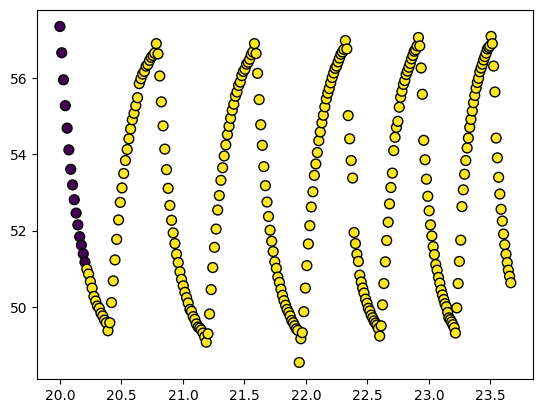

In [ ]:
plt.scatter(np.array(X_clustering)[:, 0], np.array(X_clustering)[:, 1], s=50, edgecolor="k", c= labels)
# plt.scatter(np.array(X_clustering)[:, 2], np.array(X_clustering)[:, 3], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 4], np.array(X_clustering)[:, 5], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 6], np.array(X_clustering)[:, 7], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 8], np.array(X_clustering)[:, 9], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 10], np.array(X_clustering)[:, 11], s=50, edgecolor="k")

plt.show()

In [ ]:
dbscan = DBSCAN().fit(X_clustering)
print('rand_score:', rand_score(labels, np.array(y_clustering)))
print('silhouette_score:', silhouette_score(np.array(X_clustering), labels))

rand_score: 0.9046822742474916
silhouette_score: 0.8149787253552382


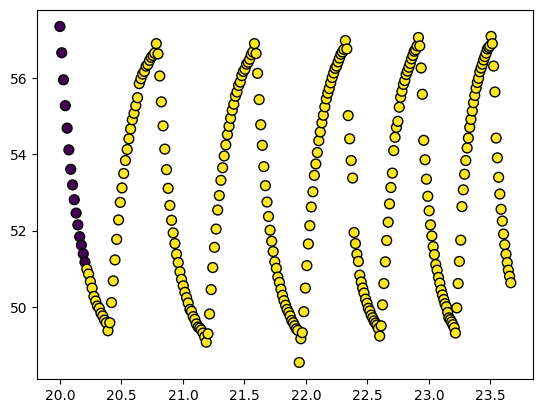

In [ ]:
plt.scatter(np.array(X_clustering)[:, 0], np.array(X_clustering)[:, 1], s=50, edgecolor="k", c= labels)
# plt.scatter(np.array(X_clustering)[:, 2], np.array(X_clustering)[:, 3], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 4], np.array(X_clustering)[:, 5], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 6], np.array(X_clustering)[:, 7], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 8], np.array(X_clustering)[:, 9], s=50, edgecolor="k")
# plt.scatter(np.array(X_clustering)[:, 10], np.array(X_clustering)[:, 11], s=50, edgecolor="k")

plt.show()

In [ ]:
agl = AgglomerativeClustering().fit(X_clustering)
print('rand_score:', rand_score(labels, np.array(y_clustering)))
print('silhouette_score:', silhouette_score(np.array(X_clustering), labels))

rand_score: 0.9046822742474916
silhouette_score: 0.8149787253552382
